In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../scripts/')
import config as cfg
sys.path.append('../scripts/crnn/')


# Comparison

## GITZAN

In [58]:
def plot_cm(targets, preds, genres, title, labels_order=None):
    cm = confusion_matrix(targets, preds, labels=labels_order)
    norm_cm = np.around((cm.T/np.sum(cm, axis=1)).T, 2)
    plt.figure(dpi=150)
    sns.heatmap(norm_cm, annot=True, cmap='Blues')
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    plt.yticks(tick_marks, genres, rotation=0)

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [3]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve

### ANFIS

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
res_path = cfg.DATASET_PATH + 'results.txt'
with open(res_path) as f:
    results = f.readlines()
results = np.array([[r.split()[0], r.split()[1]] for r in results])

In [6]:
target = results[:, 1].astype(int)
preds = results[:, 0].astype(int)

In [56]:
genres_map_anfis = {'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [8]:
genres_anfis = list(genres_map_anfis.keys())

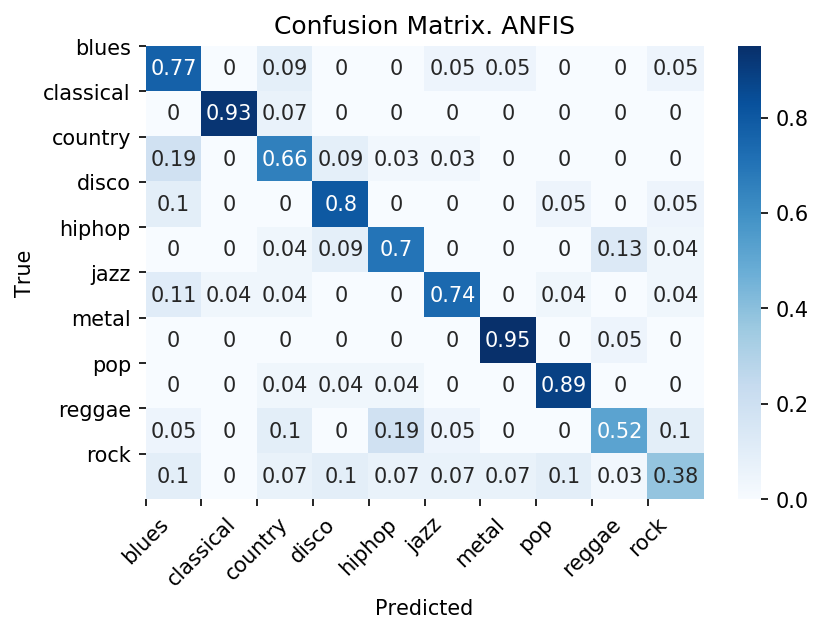

In [59]:
plot_cm(target, preds, genres_anfis, title='Confusion Matrix. ANFIS')

In [50]:
res_vals_anfis = []
for i in range(1,11):
    args = np.where(target == i)
    res_vals_anfis.append(accuracy_score(target[args], preds[args]))
res_vals_anfis = np.around(np.array(res_vals_anfis), 3)

### CNN

In [13]:
import pickle

In [78]:
with open(cfg.DATASET_PATH + 'genres_map.pckl', 'rb') as f:
    genres_map = pickle.load(f)
genres = list(genres_map.keys())

In [15]:
g_to_anfis = []
for ga in genres_anfis:
    for i, g in enumerate(genres):
        if g == ga:
            g_to_anfis.append(i)

In [16]:

from music_tagger_cnn import MusicTaggerCNN
import os
import pickle
from sklearn.model_selection import train_test_split
from keras.utils import np_utils


Using Theano backend.


In [17]:
if os.path.exists(cfg.DATASET_PATH + 'features.pckl'):
    with open(cfg.DATASET_PATH + 'features.pckl', 'rb') as f:
        X = pickle.load(f)
    with open(cfg.DATASET_PATH + 'targets.pckl', 'rb') as f:
        y = pickle.load(f)
        


In [18]:
nb_classes = 10

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=23)

In [38]:
y_test = np.array(y_test)

In [20]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_val = np_utils.to_categorical(y_val, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [21]:
model_cnn = MusicTaggerCNN(weights='msd', input_tensor=(1, 96, 1366))
model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [22]:
model_cnn.load_weights('/home/stasdon/git/temp/musicgenrerecognition/scripts/crnn/models_trained/cnn_net_adam_GTZAN_OLD/weights/01-0.89.hdf5')

In [23]:
preds_cnn = model_cnn.predict(X_test, batch_size=cfg.BATCH_SIZE, verbose=1)

165/165 [==============================] - 59s     


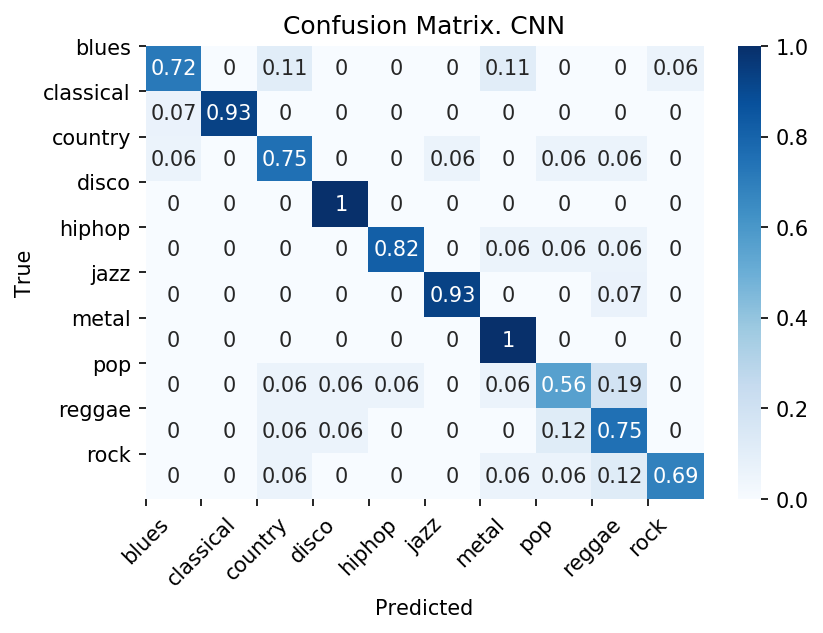

In [61]:
y_pred_cnn = np.argmax(preds_cnn, axis=1)
plot_cm(y_test, y_pred_cnn, np.array(genres)[g_to_anfis], labels_order=g_to_anfis, title='Confusion Matrix. CNN')

In [51]:
res_vals_cnn = []
for i in g_to_anfis:
    args = np.where(y_test == i)
    res_vals_cnn.append(accuracy_score(y_test[args], y_pred_cnn[args]))
res_vals_cnn = np.around(np.array(res_vals_cnn), 3)

### Mel-spectrograms samples

In [40]:
import librosa
import librosa.display
from audio_processor import compute_melgram

In [41]:
labels_df = pd.read_csv(cfg.LABELS_PATH)

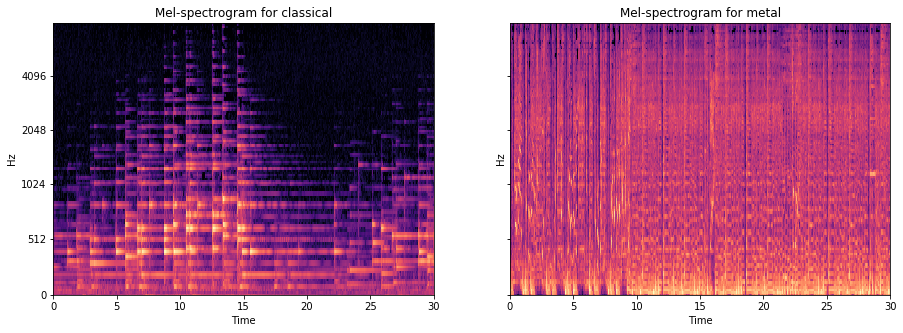

In [62]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5)) 
y, sr = librosa.load(cfg.AUDIO_DIR + labels_df.iloc[501].track_id)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time', ax=ax[0])
ax[0].set_title('Mel-spectrogram for classical')

y, sr = librosa.load(cfg.AUDIO_DIR + labels_df.iloc[101].track_id)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time', ax=ax[1])
ax[1].set_title('Mel-spectrogram for metal')
plt.show()

###  CRNN

In [30]:
from tagger_net import MusicTaggerCRNN

In [31]:
model_crnn = MusicTaggerCRNN(weights='msd', input_tensor=(1, 96, 1366))
model_crnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Shape.0


In [32]:
model_crnn.load_weights('/home/stasdon/git/temp/musicgenrerecognition/scripts/crnn/models_trained/crnn_net_adam_GTZAN_OLD/weights/34-0.72.hdf5')


In [63]:
model_crnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 96, 1366)   0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 1, 96, 1440)   0           input_1[0][0]                    
____________________________________________________________________________________________________
bn_0_freq (BatchNormalization)   (None, 1, 96, 1440)   5760        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 64, 96, 1440)  640         bn_0_freq[0][0]                  
___________________________________________________________________________________________

In [34]:
preds_crnn = model_crnn.predict(X_test, batch_size=cfg.BATCH_SIZE, verbose=1)

165/165 [==============================] - 147s    


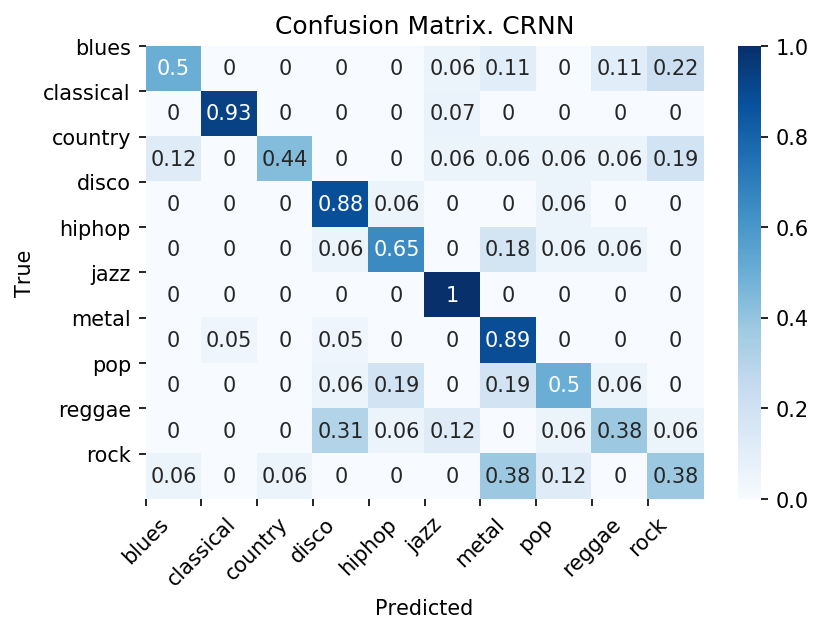

In [62]:
y_pred_crnn = np.argmax(preds_crnn, axis=1)
plot_cm(y_test, y_pred_crnn, np.array(genres)[g_to_anfis], labels_order=g_to_anfis, title='Confusion Matrix. CRNN')

In [45]:
res_vals_crnn = []
for i in g_to_anfis:
    args = np.where(y_test == i)
    res_vals_crnn.append(accuracy_score(y_test[args], y_pred_crnn[args]))
res_vals_crnn = np.around(np.array(res_vals_crnn), 3)

### All results

In [57]:
res_df = pd.DataFrame(np.column_stack((list(genres_map_anfis.keys()), res_vals_anfis, 
                                       res_vals_cnn, res_vals_crnn)), 
                      columns=['Genre', 'ANFIS', 'CNN', 'CRNN'])
res_df.set_index(['Genre'])


,ANFIS,CNN,CRNN
Genre,,,
blues,0.773,0.722,0.5
classical,0.931,0.933,0.933
country,0.656,0.75,0.438
disco,0.8,1.0,0.882
hiphop,0.696,0.824,0.647
jazz,0.741,0.933,1.0
metal,0.947,1.0,0.895
pop,0.893,0.562,0.5
reggae,0.524,0.75,0.375


In [74]:
res_df[['ANFIS', 'CNN', 'CRNN']] = res_df[['ANFIS', 'CNN', 'CRNN']].astype(float)

In [75]:
res_df.mean()

ANFIS    0.7340
CNN      0.8162
CRNN     0.6545
dtype: float64